In [1]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


print("Running...")


thr_std=0.2


E = Events("CheatedRecoFile_1.root")


view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")


u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x


v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

Running...


In [38]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx


In [3]:
def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


In [4]:
def least_z(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    min_z = np.amin(AoI_z)
    ind = np.where(min_z)[0]
    min_x = AoI_x[ind]
    #print("Least z prediction for vertex location: (x-position, z-position, plane)=", min_x, min_z, plane)
    return min_z, min_x

In [5]:
def phi_hist(plane, event_number, thresholding=True, no_std=thr_std, leastz=False, centre_coord=(0,0), no_sectors=20, centre=0, printhist=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    if leastz:
        centre_coord = least_z(plane, event_number, thresholding, no_std)
    
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre))
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    if printhist:
        plt.hist(hist_data, hist_bins)
        plt.show()

    return norm_score

In [6]:
def rfunc(r):
    return 1/(r+1)



def rphi(plane, event_number, thresholding=True, no_std=thr_std, centre_coord=(0,0), func=rfunc, no_sectors=20, centre=0):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    
    cen_r = (centred_x**2 + centred_z**2)**0.5
    #distance from central point to every other point
    

    
    
    weight = func(cen_r)

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre), weights=weight)
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    

    return norm_score

In [39]:
def optimise_phi(plane, event_number, thresholding=True, no_std=thr_std, no_sectors=20, centre=0, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in tqdm(range(no_points)):
        centre_co = (AoI_z[i], AoI_x[i])
        score_arr[i] = rphi(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind]


In [42]:
def accuracy(plane, function, no_events, thresholding=True, no_std=thr_std):
    Zvert = []
    Zvert_true = []
    Xvert = []
    Xvert_true = []
    
    for i in tqdm(range(no_events)):
        AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, i, thresholding, no_std)
        Zvert_place, Xvert_place = function(plane, i)[0], function(plane, i)[1]
        Zvert.append(Zvert_place)
        Xvert.append(Xvert_place)
        Zvert_true.append(Zvert_true_place)
        Xvert_true.append(Xvert_true_place)
    
    print(Zvert_true)
    print(Zvert)
    print(Xvert_true)
    print(Xvert)
    
    delta_z = np.array(Zvert_true) - np.array(Zvert)
    delta_x = np.array(Xvert_true) - np.array(Xvert)
    delta_r2 = delta_z**2 + delta_x**2
    
    print(delta_r2)
    data, bins = np.histogram(delta_r2, 30)
    
    plt.hist(data, bins=10)
    plt.show()

    return 0

100%|██████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 4980.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 572/572 [00:00<00:00, 4925.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 5250.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 5254.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 7614.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3000.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 507/507 [00:00<00:00, 4650.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 857/857 [00:00<00:00, 4458.50it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 2351/2351 [00:00<00:00, 3239.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 4854.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 517/517 [00:00<00:00, 5233.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 4995.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 4168.43it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1188/1188 [00:00<00:00, 4183.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 5460.32it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2433/2433 [00:00<00:00, 3339.10it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 835/835 [00:00<00:00, 4619.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 725/725 [00:00<00:00, 4677.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 4892.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 5104.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 5371.17it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2058/2058 [00:00<00:00, 3598.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 808/808 [00:00<00:00, 4804.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 571/571 [00:00<00:00, 5006.67it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 562/562 [00:00<00:00, 4711.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 4948.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 5080.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 4673.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 426/426 [00:00<00:00, 5015.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 954/954 [00:00<00:00, 4483.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 5177.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 4954.60it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 4636.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 4681.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 4259.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 4529.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 5267.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 842/842 [00:00<00:00, 4495.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 842/842 [00:00<00:00, 4587.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 4939.65it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4957.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4744.53it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1574/1574 [00:00<00:00, 3974.69it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1291/1291 [00:00<00:00, 3994.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 4725.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 504/504 [00:00<00:00, 5180.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 5254.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [00:00<00:00, 4897.82it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 927/927 [00:00<00:00, 4390.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 5168.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 4865.94it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1916/1916 [00:00<00:00, 3546.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<00:00, 4576.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 355/355 [00:00<00:00, 5284.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 5578.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 598/598 [00:00<00:00, 4832.03it/s]

100%|███████████████████████████

[291.1207, 494.05786, 341.77722, 455.0051, 959.9064, 426.93542, 319.68967, -171.83583, 675.9254, 445.98267, 131.00749, 720.2755, 133.88927, -133.02438, 235.06177, 1357.4491, -147.41017, 528.4036, 457.39587, 788.36096, 1417.59, 861.8559, 697.4666, -26.0692, 1250.6613, 1086.3722, 790.91046, 754.70447, -137.7611, 221.98288, 1023.31244, 36.347527, 149.12357, 445.7254, 357.69812, 775.26556, 257.0839, 186.51338, 159.67578, 926.47375, 64.34443, 972.033, 367.14014, -34.13812, 377.09012, 542.9882, 74.01296, 969.67804, 446.44275, 901.8806, 471.43436, 595.22437, 984.6029, 908.04956, 1148.6803, 256.32147, 277.04102, 80.12139, 339.58228, 3.2357166, 864.9204, 1114.9996, -117.95313, 542.09674, 186.51617, 810.6721, 1142.3645, 159.04356, 621.39996, 1317.3804, -10.000719, 17.371881, 787.031, 62.910343, 172.54678, 439.05447, 745.623, 93.64259, 764.51245, 702.78217, 206.62909, 46.92906, 268.22037, 343.1054, 1138.7136, 577.27136, 721.97095, 559.3699, -296.54315, 614.42706, 84.539, 351.41876, 28.839323, 574

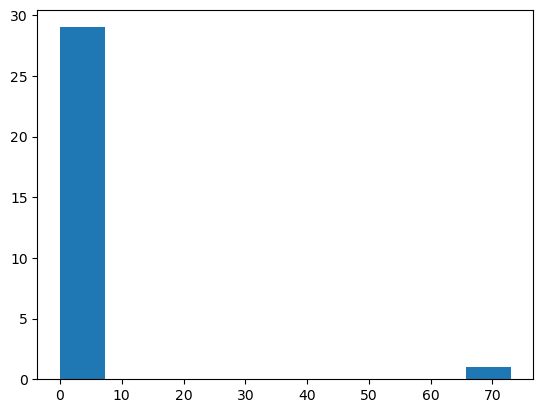

0

In [43]:
accuracy("u", optimise_phi, 100)